In [1]:
# default_exp synthetic_data

In [2]:
# hide
# export

import torch
import matplotlib.pyplot as plt

In [3]:
# export

class DummyDataset(torch.utils.data.Dataset):

    def __init__(self, n_samples=100, n_cat_feats=2, n_cont_feats=2, n_targets=1, len_ts=24, n_dim=2):

        self.n_samples = n_samples
        if n_dim == 2:
            self.cat = torch.ones(n_samples, n_cat_feats)
            self.cont = torch.ones(n_samples, n_cont_feats)
        elif n_dim == 3:
            self.cat = torch.ones(n_samples, n_cat_feats, len_ts)
            self.cont = torch.ones(n_samples, n_cont_feats, len_ts)
            #self.y = torch.ones(n_samples, n_targets, len_ts)
        elif n_dim == 4:
            self.cat = torch.ones(n_samples, n_cat_feats, len_ts, len_ts)
            self.cont = torch.ones(n_samples, n_cont_feats, len_ts, len_ts)
            #self.y = torch.ones(n_samples, n_targets, len_ts, len_ts)
        self.y = torch.ones(n_samples, n_targets)

    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, idx):
        x_cat = self.cat[idx, :]
        x_cont = self.cont[idx, :]
        y = self.y[idx, :]
        return x_cat, x_cont, y

In [4]:
n_dim = 2
data = DummyDataset(n_dim=n_dim)
dl = torch.utils.data.DataLoader(data, batch_size=32, shuffle=True, drop_last=True)
for x_cat, x_cont, y in dl:
    print(x_cat.shape, x_cont.shape, y.shape)
    assert(x_cat.dim()==x_cont.dim()==n_dim)

torch.Size([32, 2]) torch.Size([32, 2]) torch.Size([32, 1])
torch.Size([32, 2]) torch.Size([32, 2]) torch.Size([32, 1])
torch.Size([32, 2]) torch.Size([32, 2]) torch.Size([32, 1])


In [5]:
n_dim = 3
data = DummyDataset(n_dim=n_dim)
dl = torch.utils.data.DataLoader(data, batch_size=32, shuffle=True, drop_last=True)
for x_cat, x_cont, y in dl:
    print(x_cat.shape, x_cont.shape, y.shape)
    assert(x_cat.dim()==x_cont.dim()==n_dim)

torch.Size([32, 2, 24]) torch.Size([32, 2, 24]) torch.Size([32, 1])
torch.Size([32, 2, 24]) torch.Size([32, 2, 24]) torch.Size([32, 1])
torch.Size([32, 2, 24]) torch.Size([32, 2, 24]) torch.Size([32, 1])


In [6]:
n_dim = 4
data = DummyDataset(n_dim=n_dim)
dl = torch.utils.data.DataLoader(data, batch_size=32, shuffle=True, drop_last=True)
for x_cat, x_cont, y in dl:
    print(x_cat.shape, x_cont.shape, y.shape)
    assert(x_cat.dim()==x_cont.dim()==n_dim)

torch.Size([32, 2, 24, 24]) torch.Size([32, 2, 24, 24]) torch.Size([32, 1])
torch.Size([32, 2, 24, 24]) torch.Size([32, 2, 24, 24]) torch.Size([32, 1])
torch.Size([32, 2, 24, 24]) torch.Size([32, 2, 24, 24]) torch.Size([32, 1])


In [7]:
# export

class SineDataset(torch.utils.data.Dataset):

    def __init__(self, n_samples=100, n_classes=2, n_features=2, len_ts=24, noise=0.05):
        self.n_samples = n_samples
        self.n_classes = n_classes
        self.n_features = n_features
        self.len_ts = len_ts
        self.amp_min = 0.2
        self.amp_max = 0.8
        self.freq_min = 0.0
        self.freq_max = 3.0
        self.phase_min = 0.0
        self.phase_max = 2.0*torch.pi
        self.noise = noise
        self.cat_data = torch.zeros(self.n_samples*self.n_classes, self.n_features, self.len_ts)
        self.cont_data = torch.zeros(self.n_samples*self.n_classes, self.n_features, self.len_ts)
        self.target = torch.zeros(self.n_samples*self.n_classes, 1)
        
        self.generate_series()
        self.cat_data = (self.cat_data-self.cat_data.min())/(self.cat_data.max()-self.cat_data.min())
        self.cont_data = (self.cont_data-self.cont_data.min())/(self.cont_data.max()-self.cont_data.min())
        
    def generate_series(self):
        for c in range(self.n_classes):
            t = torch.linspace(0, 1, self.len_ts)
            amplitudes = torch.distributions.Uniform(self.amp_min, self.amp_max).sample((1, self.n_features))
            frequencies = torch.distributions.Uniform(self.freq_min, self.freq_max).sample((1, self.n_features))
            phases = torch.distributions.Uniform(self.phase_min, self.phase_max).sample((1, self.n_features))
            for idx in range(self.n_samples):
                self.target[c*self.n_samples + idx, :] = c
                for f_idx in range(self.n_features):
                    a = amplitudes[:, f_idx]
                    f = frequencies[:, f_idx]
                    p = phases[:, f_idx]
                    self.cat_data[c*self.n_samples + idx, f_idx, :] = p + self.noise*torch.randn_like(t)
                    self.cont_data[c*self.n_samples + idx, f_idx, :] = a*torch.sin(2*torch.pi*f*t + p) + self.noise*torch.randn_like(t)
        
    def __len__(self):
        return self.n_samples*self.n_classes

    def __getitem__(self, idx):
        x_cat = self.cat_data[idx, :]
        x_cont = self.cont_data[idx, :]
        y = self.target[idx, :]
        return x_cat, x_cont, y

In [8]:
x_cat.min()

tensor(1.)

In [9]:
data = SineDataset()
dl = torch.utils.data.DataLoader(data, batch_size=32, shuffle=True, drop_last=True)
for x_cat, x_cont, y in dl:
    assert(x_cat.max() <= 1 and x_cat.min() >= 0)
    assert(x_cont.max() <= 1 and x_cont.min() >= 0)
    print(x_cat.shape, x_cont.shape, y.shape)
print(y[:, 0])

torch.Size([32, 2, 24]) torch.Size([32, 2, 24]) torch.Size([32, 1])
torch.Size([32, 2, 24]) torch.Size([32, 2, 24]) torch.Size([32, 1])
torch.Size([32, 2, 24]) torch.Size([32, 2, 24]) torch.Size([32, 1])
torch.Size([32, 2, 24]) torch.Size([32, 2, 24]) torch.Size([32, 1])
torch.Size([32, 2, 24]) torch.Size([32, 2, 24]) torch.Size([32, 1])
torch.Size([32, 2, 24]) torch.Size([32, 2, 24]) torch.Size([32, 1])
tensor([1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0.,
        0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0.])


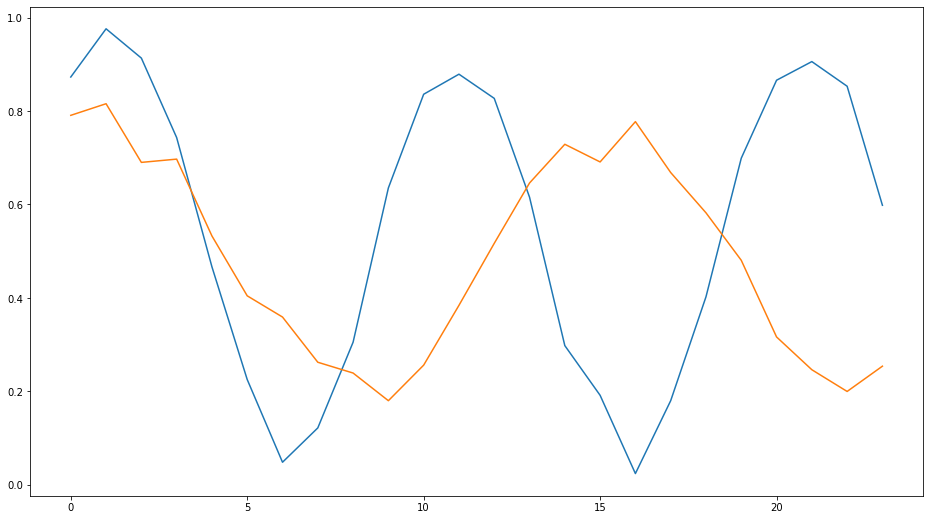

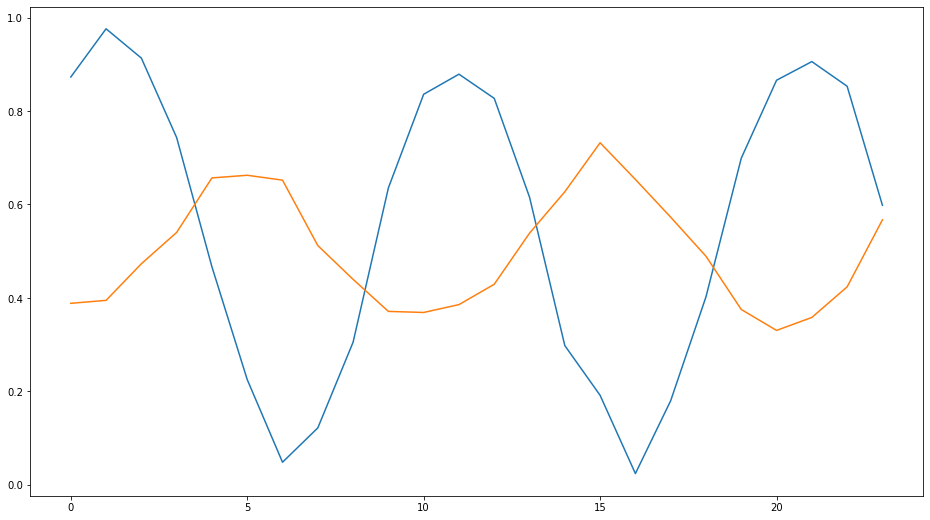

In [10]:
plt.figure(figsize=(16, 9))
plt.plot(x_cont[0, 0, :])
plt.plot(x_cont[1, 0, :])
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(x_cont[0, 0, :])
plt.plot(x_cont[0, 1, :])
plt.show()

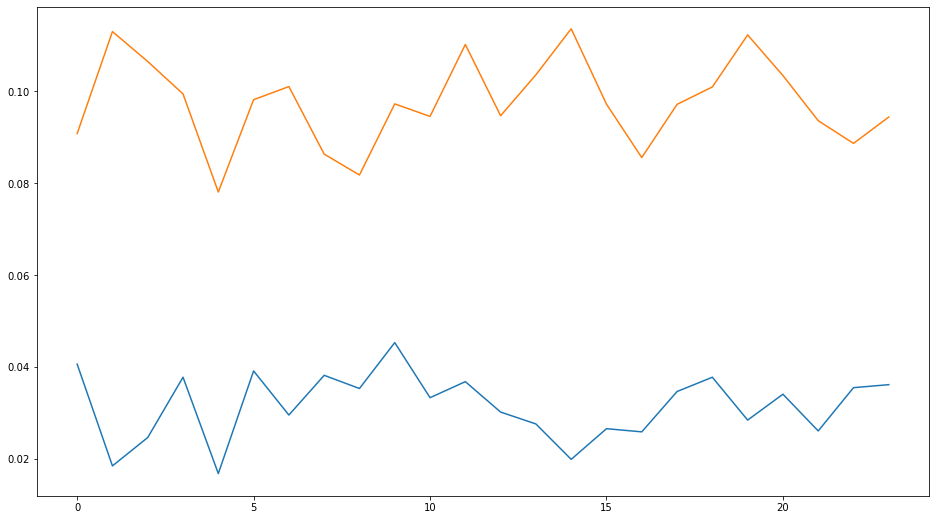

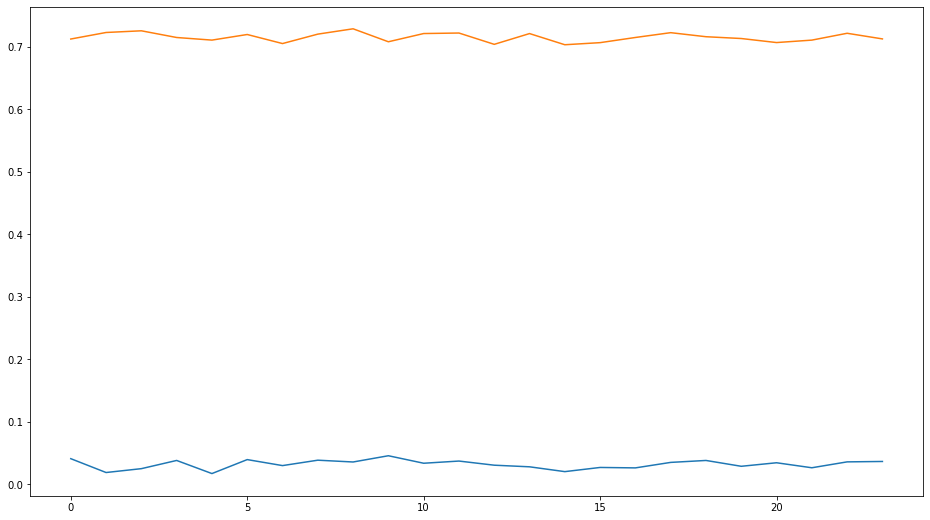

In [11]:
plt.figure(figsize=(16, 9))
plt.plot(x_cat[0, 0, :])
plt.plot(x_cat[1, 0, :])
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(x_cat[0, 0, :])
plt.plot(x_cat[0, 1, :])
plt.show()